# CNN + GlobalMaxPool 
Model: Embed mask, Conv1D, GlobalMaxPool, Dense, Dropout (can't stop the overfit)

Coding len 2000-4000

Cross validation 5 folds 5 epochs, accuracy mean 69.97% +/- 0.91, F1 mean 63.09% +/- 3.35

4 min on CoLab GPU

In [12]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-21 13:33:09.325496
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=2000
MAXLEN=4000   

In [14]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [15]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [18]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-21 13:33:11.050201
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-21 13:33:11.082851
Load sequence...
2022-12-21 13:33:37.899260
Num IDs: 18084
Example IDs: [('ENSG00000162571', 'ENST00000379289.6'), ('ENSG00000131584', 'ENST00000354700.10'), ('ENSG00000162576', 'ENST00000477278.3'), ('ENSG00000197530', 'ENST00000505820.7')]
Count 8030 ones out of 18084 labels.
Example labels: [0, 0, 0, 0]
Num counts: 18084
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    pool_layer = GlobalMaxPooling1D()
    #flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    rnn.add(den1_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-21 13:33:38.871596
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3997, 4)           1028      
                                                                 
 conv1d_6 (Conv1D)           (None, 3990, 64)          2112      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                   

## Training

In [21]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-21 13:33:39.088232
2022-12-21 13:33:39.088413
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (14388, 3997) (14388, 1)
Valid sizes (3696, 3997) (3696, 1)
Train set ones/size 6390 / 14388
Valid set ones/size 1640 / 3696
BUILD MODEL
COMPILE
FIT
2022-12-21 13:33:43.535573
Epoch 1/5
450/450 [==============================] - 6s 11ms/step - loss: 0.6342 - accuracy: 0.6401 - val_loss: 0.6089 - val_accuracy: 0.6810
Epoch 2/5
450/450 [==============================] - 4s 10ms/step - loss: 0.5739 - accuracy: 0.7173 - val_loss: 0.5965 - val_accuracy: 0.6962
Epoch 3/5
450/450 [==============================] - 5s 11ms/step - loss: 0.5401 - accuracy: 0.7408 - val_loss: 0.5671 - val_accuracy: 0.7054
Epoch 4/5
450/450 [==============================] - 5s 10ms/step - loss: 0.5151 - accuracy: 0.7597 - val_loss: 0.5657 - val_accuracy: 0.6975
Epoch 5/5
450/450 [==============================] - 5s 10ms/step - loss: 0.4957 - accuracy: 0.7781 - val_loss: 0.5748 - val_a

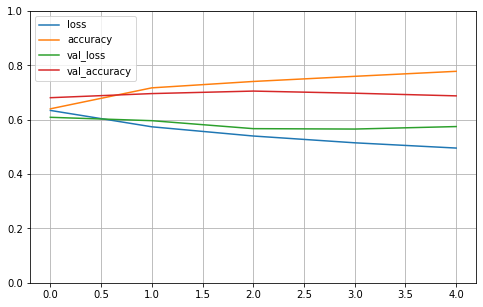

Compute valiation accuracy
2022-12-21 13:34:25.491001
Range of scores: 0.011457887 to 0.9350241
Predicted zeros and ones 2442 1254
Accuracy: 68.78% Precision: 69.38% Recall: 53.05% F1: 60.12%
2022-12-21 13:34:26.269791
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (14453, 3997) (14453, 1)
Valid sizes (3631, 3997) (3631, 1)
Train set ones/size 6483 / 14453
Valid set ones/size 1547 / 3631
BUILD MODEL
COMPILE
FIT
2022-12-21 13:34:30.648769
Epoch 1/5
452/452 [==============================] - 5s 11ms/step - loss: 0.6315 - accuracy: 0.6353 - val_loss: 0.5564 - val_accuracy: 0.7262
Epoch 2/5
452/452 [==============================] - 5s 10ms/step - loss: 0.5623 - accuracy: 0.7252 - val_loss: 0.5787 - val_accuracy: 0.6948
Epoch 3/5
452/452 [==============================] - 4s 10ms/step - loss: 0.5383 - accuracy: 0.7414 - val_loss: 0.5386 - val_accuracy: 0.7183
Epoch 4/5
452/452 [==============================] - 5s 10ms/step - loss: 0.5115 - accuracy: 0.7644 - val_loss: 0

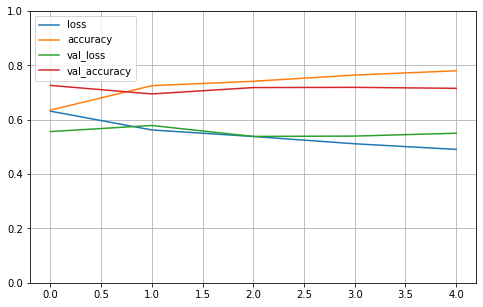

Compute valiation accuracy
2022-12-21 13:35:12.813236
Range of scores: 0.012609421 to 0.9740762
Predicted zeros and ones 1865 1766
Accuracy: 71.55% Precision: 64.55% Recall: 73.69% F1: 68.82%
2022-12-21 13:35:13.466239
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (14355, 3997) (14355, 1)
Valid sizes (3729, 3997) (3729, 1)
Train set ones/size 6379 / 14355
Valid set ones/size 1651 / 3729
BUILD MODEL
COMPILE
FIT
2022-12-21 13:35:17.989660
Epoch 1/5
449/449 [==============================] - 5s 11ms/step - loss: 0.6251 - accuracy: 0.6473 - val_loss: 0.5686 - val_accuracy: 0.7230
Epoch 2/5
449/449 [==============================] - 4s 10ms/step - loss: 0.5641 - accuracy: 0.7184 - val_loss: 0.5613 - val_accuracy: 0.7233
Epoch 3/5
449/449 [==============================] - 5s 10ms/step - loss: 0.5369 - accuracy: 0.7445 - val_loss: 0.5596 - val_accuracy: 0.7300
Epoch 4/5
449/449 [==============================] - 4s 10ms/step - loss: 0.5132 - accuracy: 0.7583 - val_loss: 0

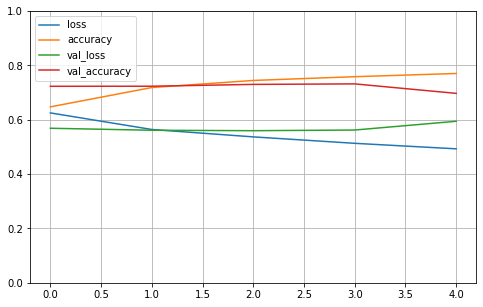

Compute valiation accuracy
2022-12-21 13:35:41.758318
Range of scores: 0.011302532 to 0.9368776
Predicted zeros and ones 2544 1185
Accuracy: 69.70% Precision: 71.98% Recall: 51.67% F1: 60.16%
2022-12-21 13:35:42.528415
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (14515, 3997) (14515, 1)
Valid sizes (3569, 3997) (3569, 1)
Train set ones/size 6471 / 14515
Valid set ones/size 1559 / 3569
BUILD MODEL
COMPILE
FIT
2022-12-21 13:35:46.993327
Epoch 1/5
454/454 [==============================] - 5s 10ms/step - loss: 0.6301 - accuracy: 0.6463 - val_loss: 0.5637 - val_accuracy: 0.7173
Epoch 2/5
454/454 [==============================] - 4s 10ms/step - loss: 0.5609 - accuracy: 0.7288 - val_loss: 0.5636 - val_accuracy: 0.7089
Epoch 3/5
454/454 [==============================] - 4s 10ms/step - loss: 0.5372 - accuracy: 0.7443 - val_loss: 0.5570 - val_accuracy: 0.7159
Epoch 4/5
454/454 [==============================] - 4s 10ms/step - loss: 0.5191 - accuracy: 0.7598 - val_loss: 0

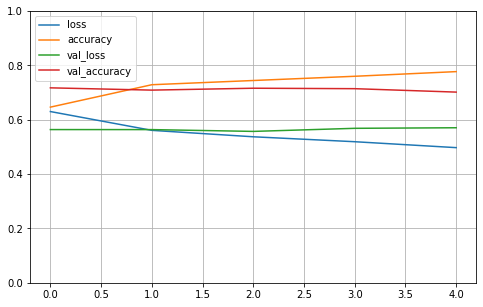

Compute valiation accuracy
2022-12-21 13:36:29.849314
Range of scores: 0.015101254 to 0.9489803
Predicted zeros and ones 2365 1204
Accuracy: 70.16% Precision: 70.51% Recall: 54.46% F1: 61.45%
2022-12-21 13:36:30.509480
Fold 5
Training example
[160 126 247 ...   0   0   0]
Train sizes (14625, 3997) (14625, 1)
Valid sizes (3459, 3997) (3459, 1)
Train set ones/size 6397 / 14625
Valid set ones/size 1633 / 3459
BUILD MODEL
COMPILE
FIT
2022-12-21 13:36:34.926236
Epoch 1/5
458/458 [==============================] - 6s 11ms/step - loss: 0.6227 - accuracy: 0.6528 - val_loss: 0.5886 - val_accuracy: 0.7037
Epoch 2/5
458/458 [==============================] - 5s 10ms/step - loss: 0.5597 - accuracy: 0.7244 - val_loss: 0.5908 - val_accuracy: 0.6964
Epoch 3/5
458/458 [==============================] - 5s 10ms/step - loss: 0.5337 - accuracy: 0.7462 - val_loss: 0.5747 - val_accuracy: 0.7014
Epoch 4/5
458/458 [==============================] - 5s 10ms/step - loss: 0.5113 - accuracy: 0.7659 - val_loss: 0

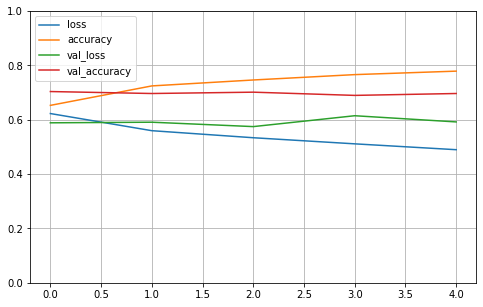

Compute valiation accuracy
2022-12-21 13:37:16.897632
Range of scores: 0.008246667 to 0.9554599
Predicted zeros and ones 2100 1359
Accuracy: 69.64% Precision: 71.45% Recall: 59.46% F1: 64.91%
2022-12-21 13:37:17.540792

Cross validation 5 folds 5 epochs
 accuracy mean 69.97% +/- 0.91
 precision mean 69.58% +/- 2.66
 recall mean 58.46% +/- 8.06
 F1 mean 63.09% +/- 3.35
2022-12-21 13:37:17.550848


In [22]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())